In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Thu Aug 17 16:11:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0    64W / 300W |  11685MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Hyperparams

In [4]:
n_mels = 768
n_outputs = 61
n_frames = 400

### Model

In [5]:
from model.model_glowtts_sid import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
print('done')

done


### Load

In [6]:
save_dir = '/data/scpark/save/lips/train08.17-1/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 140000, model, None, optimizer)

total 0


### Dataset

In [7]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'

def get_files(dir):
    data = []
    files = sorted([os.path.join(dir, file) for file in os.listdir(dir)])
    for file in files:
        if file.endswith('.npy') and 'ARKit' in file:
            data.append(file)
        if os.path.isdir(file):
            data.extend(get_files(os.path.join(dir, file)))
    return data

files = get_files(root_dir)
print(len(files))

train_datasets = []
test_datasets = []

def get_sid(file):
    names = ['No Speaker', 'jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
    for sid, name in enumerate(names):
        if name in file:
            return sid
    return 0

for file in files:
    sid = get_sid(file)
    print(sid, file)
    dataset = LipsDataset(file, n_mels, n_frames, sid=sid, mel=False)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

76
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_10_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_11_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_12_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_2_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_3_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_4_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_5_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_8_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_9_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_10_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
2

In [8]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=16, shuffle=True, batch_size=32, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [9]:
import fairseq
from torchaudio.transforms import Resample

resample = Resample(24000, 16000)

ckpt_path = "/Storage/speech/pretrained/contentvec/checkpoint_best_legacy_500.pt"
hubert, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
hubert = hubert[0]
hubert = hubert.to(device)
hubert.eval()

def get_hubert_feature(wav):
    with torch.no_grad():
        # (b, t, c)
        wav = resample(torch.Tensor(wav)).to(device)
        feature = hubert.extract_features(wav, output_layer=12)[0]
        return feature.transpose(1, 2)
print('done')

2023-08-17 16:12:25 | INFO | fairseq.tasks.hubert_pretraining | current directory is /home/scpark/projects/wav2face
2023-08-17 16:12:25 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': 'metadata', 'fine_tuning': False, 'labels': ['km'], 'label_dir': 'label', 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2023-08-17 16:12:25 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout': 0.1, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.05, 'dropout_input': 0.1, 'dropout_features': 0.1,

done


test : 0 -3.0844998359680176
test : 1 -3.2043938636779785
test : 2 -3.070847511291504
test : 3 -3.2006101608276367
test : 4 -3.179462432861328
test : 5 -3.1879944801330566
test : 6 -3.1451163291931152
test : 7 -3.1058640480041504
test : 8 -3.1730141639709473
test : 9 -3.158254623413086
test_loss : -3.151005744934082


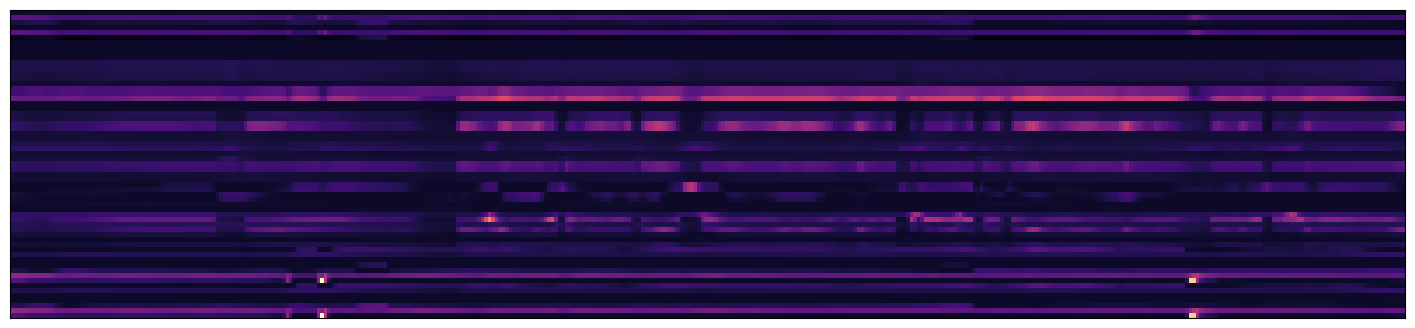

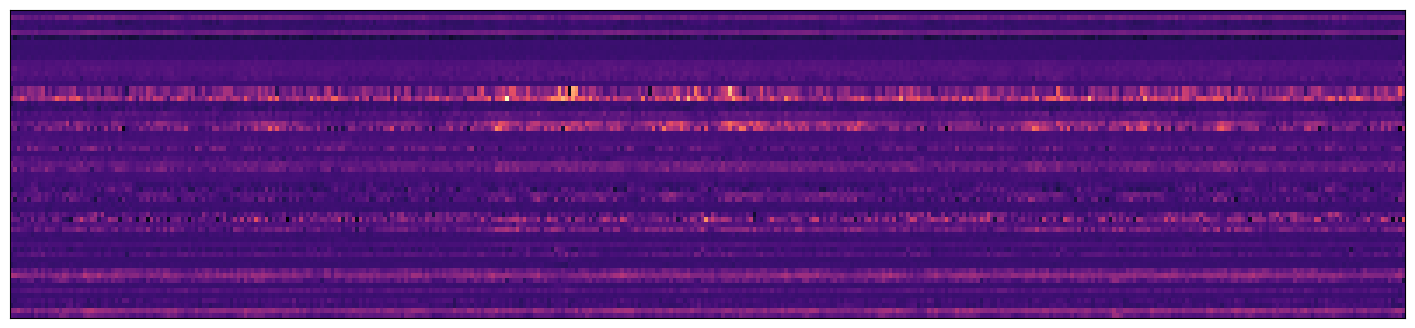

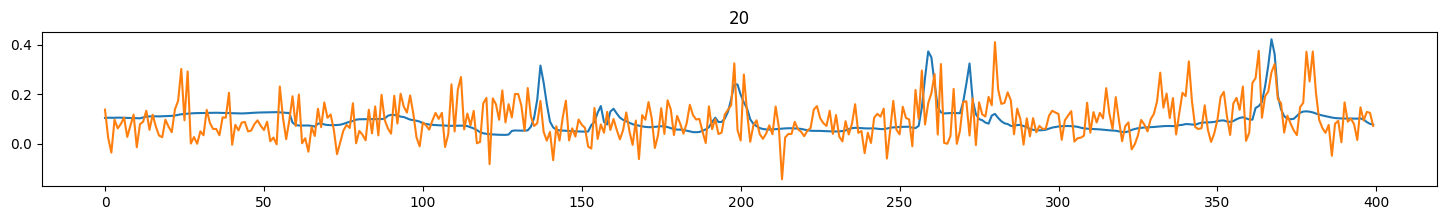

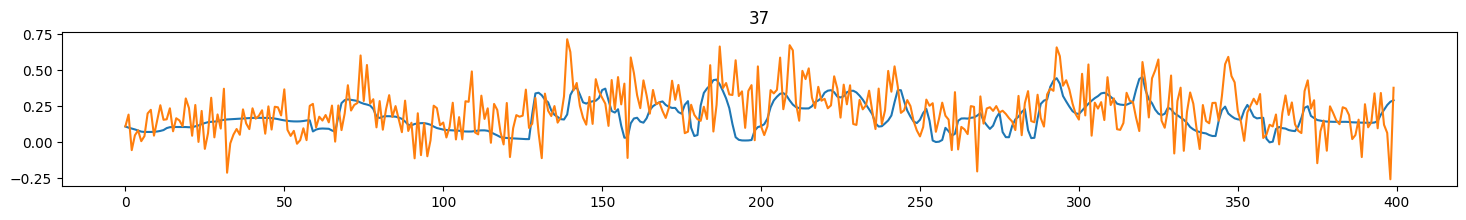

1001
loss -3.048424243927002
1001 -3.048424243927002
1002
loss -3.233865737915039
1002 -3.233865737915039
1003
loss -3.1718311309814453
1003 -3.1718311309814453
1004
loss -3.1166234016418457
1004 -3.1166234016418457
1005
loss -3.038841724395752
1005 -3.038841724395752
1006
loss -3.1503653526306152
1006 -3.1503653526306152
1007
loss -3.190964698791504
1007 -3.190964698791504
1008
loss -3.2184553146362305
1008 -3.2184553146362305
1009
loss -3.200021743774414
1009 -3.200021743774414
1010
loss -3.141371250152588
1010 -3.141371250152588
1011
loss -3.1678028106689453
1011 -3.1678028106689453
1012
loss -3.213838577270508
1012 -3.213838577270508
1013
loss -3.2113871574401855
1013 -3.2113871574401855
1014
loss -3.2148032188415527
1014 -3.2148032188415527
1015
loss -3.129362106323242
1015 -3.129362106323242
1016
loss -3.039475917816162
1016 -3.039475917816162
1017
loss -2.8527708053588867
1017 -2.8527708053588867
1018
loss -3.0356979370117188
1018 -3.0356979370117188
1019
loss -2.950327396392822

1153
loss -3.2800755500793457
1153 -3.2800755500793457
1154
loss -3.37471342086792
1154 -3.37471342086792
1155
loss -3.3359336853027344
1155 -3.3359336853027344
1156
loss -3.1459951400756836
1156 -3.1459951400756836
1157
loss -3.156822681427002
1157 -3.156822681427002
1158
loss -3.103942394256592
1158 -3.103942394256592
1159
loss -3.2261390686035156
1159 -3.2261390686035156
1160
loss -3.3118882179260254
1160 -3.3118882179260254
1161
loss -3.2531991004943848
1161 -3.2531991004943848
1162
loss -3.2949228286743164
1162 -3.2949228286743164
1163
loss -3.313812732696533
1163 -3.313812732696533
1164
loss -3.3439273834228516
1164 -3.3439273834228516
1165
loss -3.2628488540649414
1165 -3.2628488540649414
1166
loss -3.2644710540771484
1166 -3.2644710540771484
1167
loss -3.3147177696228027
1167 -3.3147177696228027
1168
loss -3.262402057647705
1168 -3.262402057647705
1169
loss -3.308412551879883
1169 -3.308412551879883
1170
loss -3.2880210876464844
1170 -3.2880210876464844
1171
loss -3.28075456619

1305
loss -3.3087220191955566
1305 -3.3087220191955566
1306
loss -3.1875481605529785
1306 -3.1875481605529785
1307
loss -3.321033477783203
1307 -3.321033477783203
1308
loss -3.290001392364502
1308 -3.290001392364502
1309
loss -3.3465967178344727
1309 -3.3465967178344727
1310
loss -3.3852176666259766
1310 -3.3852176666259766
1311
loss -3.3628344535827637
1311 -3.3628344535827637
1312
loss -3.4009485244750977
1312 -3.4009485244750977
1313
loss -3.236539840698242
1313 -3.236539840698242
1314
loss -3.393949508666992
1314 -3.393949508666992
1315
loss -3.4344935417175293
1315 -3.4344935417175293
1316
loss -3.3532958030700684
1316 -3.3532958030700684
1317
loss -3.3014988899230957
1317 -3.3014988899230957
1318
loss -3.359504222869873
1318 -3.359504222869873
1319
loss -3.4167261123657227
1319 -3.4167261123657227
1320
loss -3.3684654235839844
1320 -3.3684654235839844
1321
loss -3.2779712677001953
1321 -3.2779712677001953
1322
loss -3.3772315979003906
1322 -3.3772315979003906
1323
loss -3.2660441

1457
loss -2.670248031616211
1457 -2.670248031616211
1458
loss -3.1468119621276855
1458 -3.1468119621276855
1459
loss -3.1389546394348145
1459 -3.1389546394348145
1460
loss -3.0706424713134766
1460 -3.0706424713134766
1461
loss -3.095907211303711
1461 -3.095907211303711
1462
loss -3.068638324737549
1462 -3.068638324737549
1463
loss -3.175232410430908
1463 -3.175232410430908
1464
loss -3.1692633628845215
1464 -3.1692633628845215
1465
loss -3.040421485900879
1465 -3.040421485900879
1466
loss -3.1820783615112305
1466 -3.1820783615112305
1467
loss -3.1844959259033203
1467 -3.1844959259033203
1468
loss -3.191382884979248
1468 -3.191382884979248
1469
loss -3.209901809692383
1469 -3.209901809692383
1470
loss -3.134209632873535
1470 -3.134209632873535
1471
loss -3.23000431060791
1471 -3.23000431060791
1472
loss -3.213653087615967
1472 -3.213653087615967
1473
loss -3.2386460304260254
1473 -3.2386460304260254
1474
loss -3.3966097831726074
1474 -3.3966097831726074
1475
loss -3.275536060333252
147

1609
loss -3.373037815093994
1609 -3.373037815093994
1610
loss -3.4150233268737793
1610 -3.4150233268737793
1611
loss -3.3558125495910645
1611 -3.3558125495910645
1612
loss -3.3889946937561035
1612 -3.3889946937561035
1613
loss -3.294445037841797
1613 -3.294445037841797
1614
loss -3.3295631408691406
1614 -3.3295631408691406
1615
loss -3.4180383682250977
1615 -3.4180383682250977
1616
loss -3.433788299560547
1616 -3.433788299560547
1617
loss -3.510815143585205
1617 -3.510815143585205
1618
loss -3.4625024795532227
1618 -3.4625024795532227
1619
loss -3.4199342727661133
1619 -3.4199342727661133
1620
loss -3.484246253967285
1620 -3.484246253967285
1621
loss -3.437255382537842
1621 -3.437255382537842
1622
loss -3.4506731033325195
1622 -3.4506731033325195
1623
loss -3.575019359588623
1623 -3.575019359588623
1624
loss -3.478262424468994
1624 -3.478262424468994
1625
loss -3.488410472869873
1625 -3.488410472869873
1626
loss -3.5464863777160645
1626 -3.5464863777160645
1627
loss -3.377813816070556

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        inputs = get_hubert_feature(batch['wav'])
        inputs = F.interpolate(inputs, size=(targets.shape[2]), mode='linear')
        sid = torch.Tensor(batch['sid']).int().to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets, sid)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 1000 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 1000 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
                inputs = get_hubert_feature(batch['wav'])
                inputs = F.interpolate(inputs, size=(targets.shape[2]), mode='linear')
                sid = torch.Tensor(batch['sid']).int().to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets, sid)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            model.eval()
            with torch.no_grad():
                y_pred = model.inference(inputs, sid)

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(y_pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(y_pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 10000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)